# 2. Deduplication of mass spectra with Locality Sensitive Hashing

High-resolution LC-MS/MS datasets typically contain multiple spectra of the same or nearly identical compounds. For downstream machine learning and molecular networking, deduplicating these spectra is critical: it prevents redundancy, improves statistical analyses, and greatly reduces computational costs.

DreaMS implements fast, scalable deduplication using Locality Sensitive Hashing (LSH) with random projections, enabling the grouping of highly similar or duplicate MS/MS spectra in linear time—even across millions of spectra.


2.1. What is LSH and why do we use it for spectra clustering?

Locality Sensitive Hashing is a class of algorithms designed to efficiently find similar items in large datasets. Instead of comparing every spectrum to every other spectrum (which would be infeasible for large datasets), LSH transforms each spectrum into a compact “hash” in such a way that similar spectra are highly likely to share the same hash, while dissimilar spectra end up with different hashes.

In the context of DreaMS:
	•	Each spectrum (represented as a binned vector of m/z-intensity pairs) is projected into a high-dimensional space using random hyperplanes.
	•	The hash for each spectrum encodes which side of each hyperplane the spectrum falls on—forming a unique signature.
	•	Spectra with identical hashes are clustered together: they are “near duplicates” with extremely similar fragmentation patterns.


for DreaMS documentation use this link for documentation: https://dreams-docs.readthedocs.io/en/latest/tutorials/lsh_clustering.html

for paper use this one https://www.nature.com/articles/s41587-025-02663-3


In [3]:
import sys
from pathlib import Path

# so that `paths.py` (with PROJECT_ROOT) is on the import path
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import numpy as np
import pandas as pd
from tqdm import tqdm

from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from dreams.utils.spectra import PeakListModifiedCosine

# plotting utilities
from benchmark.utils.plots import plot_similarity_kde, plot_dissimilarity_hist_kde

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


### 2.2. Loading your processed data
We start with the high-quality, positive-ion spectra saved from the previous data preparation step from 1_data_preparation.ipynb notebook. If you’re following the pipeline, this is the _high_quality.hdf5 file produced earlier.

In [33]:
spectra_path = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated.mgf"
h5_path   = spectra_path.with_name(spectra_path.stem + "_high_quality.hdf5")
dedup_h5  = spectra_path.with_name(spectra_path.stem + "_dedup.hdf5")

In [34]:
if h5_path.exists():
    # If the HDF5 already exists, load it directly (this is fastest)
    msdata = MSData.from_hdf5(h5_path, in_mem=True)
else:
    # If not, convert from the original file and cache the result as HDF5
    msdata = MSData.load(
        spectra_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ"
    )

Loading dataset Piper_sirius_all_annotated_high_quality into memory (4758 spectra)...


2.3. Computing LSH hashes for all spectra

To efficiently cluster and deduplicate MS/MS spectra, DreaMS implements Locality Sensitive Hashing (LSH) via the BatchedPeakListRandomProjection class.


How does LSH work in DreaMS?
Each spectrum is first vectorized by binning the m/z axis (using the bin_step parameter), producing a uniform-length vector representation. Then, random hyperplanes are generated in this vector space (n_hyperplanes). For each spectrum, its position relative to each hyperplane is encoded as a bit in the hash. The resulting LSH hash is thus a unique fingerprint: spectra falling into the same hash share the same “bucket” and are clustered together.
	•	bin_step sets the width of m/z bins when constructing the spectral vector. For most use-cases, the default (0.5 m/z) is sufficient and does not heavily affect cluster granularity.
	•	n_hyperplanes determines the number of random projections, directly controlling cluster strictness:
	•	Larger values (e.g., 128) produce very fine-grained clusters, ideal for deduplication and finding true near-duplicates.
	•	Smaller values (e.g., 20) allow for looser clusters, potentially grouping structural analogs.
	•	We use n_hyperplanes=50 here, which serves as a practical compromise for most datasets 



In [45]:
specs = msdata.get_spectra()

lsh_proj = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=20)
hashes   = lsh_proj.compute(specs)

print(f"▶ Computed {len(hashes)} hashes; example hash: {hashes[0]!r}")

Computing LSHs: 100%|██████████| 4758/4758 [00:01<00:00, 3823.72it/s]


▶ Computed 4758 hashes; example hash: b'e9d2e6bb93bcc91512a2f89f0039b57312a46fc8237ba8c5521ad9993f18f649'


Notes on clustering behavior:
	•	LSH in DreaMS is optimized for precision—clusters are highly pure and group only spectra that are similar. As a result, recall is sometimes lower: true duplicates are usually not missed, but analogs with more divergent spectra may be split into separate clusters. For in-depth evaluation of clustering metrics and reproducibility, see this benchmarking notebook (https://github.com/pluskal-lab/DreaMS/blob/0d33ae141641c8551d81a68d7f88fb2162624397/experiments/clustering/clustering_evaluation.ipynb).
	•	The method is robust to spectral noise: random fluctuations in peak intensity or minor missing peaks rarely affect the resulting hash.
	•	The entire LSH hashing and clustering process operates in linear time with respect to the number of spectra, enabling you to deduplicate millions of spectra on a laptop.



2.4. Exploring hash clusters

After computing the LSH hashes for all spectra, each spectrum is now assigned to a cluster, represented by a unique hash value. Each entry in hashes is a binary string (often shown as a long hexadecimal value as b'f3e551b2a2...') that uniquely identifies the cluster for that spectrum. Each hash is derived from a boolean vector of length n_hyperplanes, where each bit represents the side of a random hyperplane into which the spectrum’s binned vector falls.


Here we are counting how many times each unique hash appears, we see how many spectra are grouped together in each cluster.

In [46]:
ls     = pd.Series(hashes)
counts = ls.value_counts()

print("▶ Total unique hashes (clusters):", counts.size)
print("▶ Top 5 cluster sizes:")
print(counts.head())

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_82557/3903886061.py:6: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = ls.value_counts()


▶ Total unique hashes (clusters): 1774
▶ Top 5 cluster sizes:
b'f3e551b2a26a0c7c0ae62a524d2d6079ddd5b426c5108fb58c7e122794c0417a'    157
b'205107727b7471785f0c0bee1fea50de5f272e7b3271621bea3cd548f1468138'     57
b'85064b0925c6644d1994093f6e315acee47c9962134c73341098cdd557a2faf0'     54
b'948f562663aeb27ee4aac44b49d41ce4c919b2536425ca4073c2740fd7b0462d'     51
b'726070d6793701e5a27a1fedaa7c45c155e1fc43d1bf6d26f7c7552724aa5be8'     48
Name: count, dtype: int64


The output shows each hash (as a hexadecimal string) and the number of spectra grouped in that cluster. The largest cluster in this dataset contains 88 spectra. We started with 4758 spectra, and after LSH you see 2799 unique hashes, this means you have identified 2799 distinct clusters, many spectra have been grouped as duplicates.


#### 2.5. Visualizing and validating clusters

To build trust in the LSH deduplication process, we will confirm that spectra grouped into the same cluster are truly highly similar.

First, we look through all clusters and find those where the cluster size is exactly 5. We then take the first such cluster as an example for further investigation.

In [49]:
small_hash = counts[counts == 5].index
assert len(small_hash) > 0, "No cluster of size 5 found!"
small_hash = small_hash[0]
small_idxs = np.where(hashes == small_hash)[0]
print(f"▶ Small cluster hash {small_hash!r} at indices", small_idxs)

▶ Small cluster hash b'a22327ff38b70657b0b6fb22aff5abbe92ef0e94847f770a69117d20cc4642ff' at indices [1208 1209 1210 1211 1212]


#### Next, we visualize the spectra in this cluster:

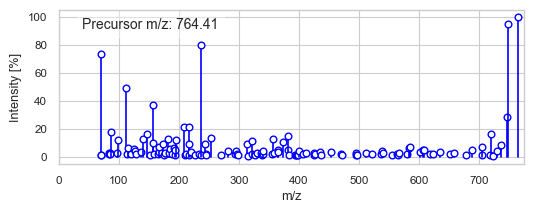

[17:52:13] SMILES Parse Error: syntax error while parsing: None
[17:52:13] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

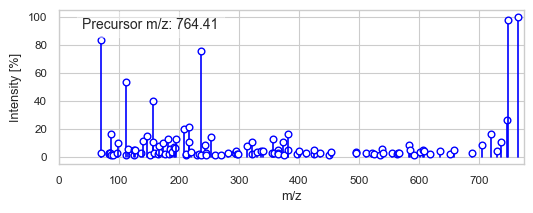

[17:52:13] SMILES Parse Error: syntax error while parsing: None
[17:52:13] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

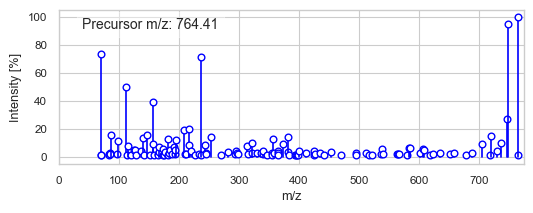

[17:52:13] SMILES Parse Error: syntax error while parsing: None
[17:52:13] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

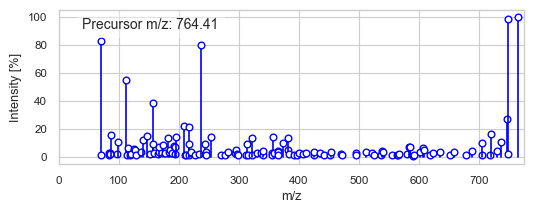

[17:52:13] SMILES Parse Error: syntax error while parsing: None
[17:52:13] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

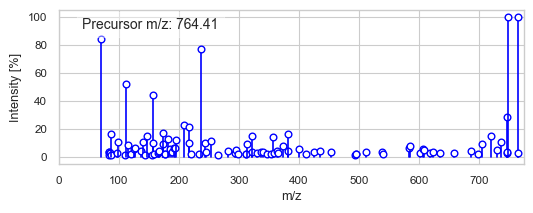

[17:52:13] SMILES Parse Error: syntax error while parsing: None
[17:52:13] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

In [50]:
for raw_i in small_idxs:
    i = int(raw_i)
    msdata.at(i, plot_mol=True)

By visually inspecting these five spectra, you observed that all have nearly identical fragmentation patterns. This confirms that the LSH deduplication groups near-duplicate spectra together.

To objectively confirm that the spectra in our chosen cluster are truly near-duplicates, we compute the pairwise similarity between all spectra in the cluster using the modified cosine similarity metric. The value of 1 means the spectra are identical.


In [51]:
cos_sim = PeakListModifiedCosine()
sim_mat_small = cos_sim.compute_pairwise(
    specs    = specs[small_idxs.astype(int)],
    prec_mzs = msdata.get_values('precursor_mz')[small_idxs.astype(int)],
    avg      = False
)
print("▶ Small cluster pairwise matrix:\n", sim_mat_small)


▶ Small cluster pairwise matrix:
 [[1.         0.99632112 0.99779079 0.99787984 0.99325132]
 [0.99632112 1.         0.99670361 0.99761276 0.99448543]
 [0.99779079 0.99670361 1.         0.99732135 0.99332847]
 [0.99787984 0.99761276 0.99732135 1.         0.994485  ]
 [0.99325132 0.99448543 0.99332847 0.994485   1.        ]]


The resulting matrix shows the cosine similarity score for every pair of spectra in the cluster. The diagonal values are all exactly 1, since each spectrum is perfectly identical to itself. The off-diagonal scores indicate the similarity between different spectra in the cluster, scores close to 1 confirm that all spectra within this cluster are indeed highly similar or even identical.

### 3) Find a cluster of size 15–20

We want to show that indeed clustered spectra are similar also for larger group.
Group spectra by identical hash, then pick one group whose size falls in our target range.

In [68]:
# count frequencies of each hash
counts = pd.Series(hashes).value_counts()

target = counts[(counts >= 50) & (counts <= 200)]
assert not target.empty, "No cluster in the desired size range found!"

# pick the first matching hash
cluster_hash = target.index[0]
cluster_size = target.iloc[0]
print(f"Selected hash {cluster_hash} with cluster size = {cluster_size}")

# indices of spectra in this cluster
i_idxs = np.where(hashes == cluster_hash)[0]

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_82557/3435749888.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = pd.Series(hashes).value_counts()


Selected hash b'27d54b33fc782095d6c75cffe721f7173876722dfa00a4c5050f945d582afdca' with cluster size = 88


### 4) Visualize intra‑cluster similarity

Compute pairwise modified cosine similarities,to see that spectra within cluster are highly similar then plot:


Pairwise modified‑cosine matrix shape: (88, 88)


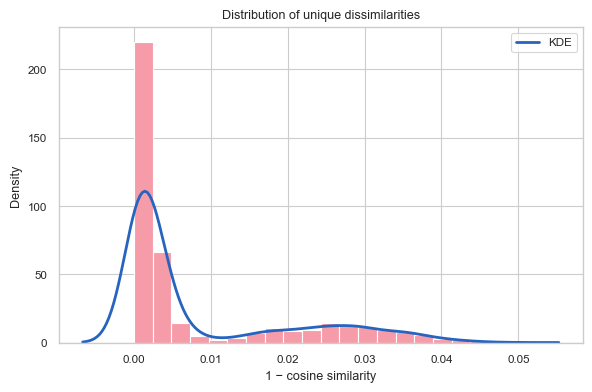

In [69]:
# extract the actual peak lists and precursor m/z for the cluster
cluster_specs = specs[i_idxs]
cluster_prec  = msdata.get_prec_mzs()[i_idxs]

# compute full pairwise similarity matrix
cos_sim = PeakListModifiedCosine()
sim_mat = cos_sim.compute_pairwise(
    specs    = cluster_specs,
    prec_mzs = cluster_prec,
    avg      = False
)
print("Pairwise modified‑cosine matrix shape:", sim_mat.shape)


# 4b) Pink histogram + lavender KDE of the affinities
plot_dissimilarity_hist_kde(sim_mat)

Conclusion:LSH clustering reliably groups highly similar spectra together, as evidenced by the tight intra‑cluster similarity distributions.

Next steps:– Repeat across additional files or whole merged dataset– Tune bin_step & n_hyperplanes– Integrate deduplication into downstream embedding pipelines

# Saving deduplicated data

In [18]:
# ### 2) Deduplicate by hash and save final HDF5

# build a small DataFrame for dedupe
df_map = pd.DataFrame({
    'hash': hashes,
    'scan_index': np.arange(len(hashes))
})
print("▶ Before dedupe, spectra count:", len(df_map))


▶ Before dedupe, spectra count: 4758


In [19]:
# drop duplicates, keep first occurrence per hash
df_map = df_map.drop_duplicates(subset=['hash'])
keep_idxs = np.sort(df_map['scan_index'].values)
print("▶ After dedupe, spectra count:", len(keep_idxs))


▶ After dedupe, spectra count: 2799


In [22]:
# write out deduplicated HDF5
out_h5 = h5_path.with_name(h5_path.stem + "_dedup.hdf5")
msdata_dedup = msdata.form_subset(keep_idxs, out_pth=out_h5)
print("▶ Saved deduplicated HDF5 to", out_h5)

▶ Saved deduplicated HDF5 to /Users/macbook/CODE/DreaMS_MIMB/data/rawfiles/202312_20_P09-Leaf-r1_1uL_high_quality_dedup.hdf5
